In [ ]:
#코랩에서 작성할 경우 아래 주석을 해제해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 40.4 MB/s eta 0:00:00


In [ ]:
!pip install konlpy==0.6.0 pandas scikit-learn matplotlib numpy

In [ ]:
!apt-get update -y
!apt-get install -y fonts-nanum

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,775 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,575 kB]
Hit:13 https://ppa.launchpadcontent.

In [ ]:
# 1) 나눔글꼴 설치 (Colab 전용)
!apt-get -qq -y install fonts-nanum > /dev/null

# 2) Matplotlib에 폰트 등록
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import warnings, re

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_manager.fontManager.addfont(font_path)
rcParams['font.family'] = 'NanumGothic'
rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 3) Glyph 경고 숨기기 (원하면)
warnings.filterwarnings(
    "ignore",
    message="Glyph .* missing from font",
    category=UserWarning
)


=== 전체 상위 표현 ===
      phrase  freq
0      대출 규제  7724
1      정비 사업  6266
2      전용 면적  4192
3      산업 개발  4187
4      지하 지상  4091
5      주택 공급  3837
6      가구 규모  3182
7     한국 부동산  3063
8      순위 청약  3007
9      매매 가격  2740
10     개발 사업  2736
11     현대 건설  2679
12    아파트 단지  2551
13     사업 추진  2501
14    아파트 매매  2454
15     토지 거래  2427
16     거래 허가  2383
17  토지 거래 허가  2354
18    시공사 선정  2335
19     허가 구역  2174
20     삼성 물산  2158
21     개포 우성  2124
22  거래 허가 구역  2118
23     주거 환경  2113
24     규제 지역  2103
25    아파트 가격  2080
26    재건축 사업  1956
27    압구정 구역  1906
28     정비 계획  1776
29     가격 상승  1767

=== 일자별 Top 표현 ===

[2025-05-27]
  지하 안전 : 197
  안전 관리 : 139
  건설 사고 : 128
  산업 개발 : 123
  정비 사업 : 123
  굴착 사장 : 106
  평균 월세 : 99
  지반 탐사 : 97
  국토 안전 : 95
  안전 관리원 : 95

[2025-05-28]
  재정 촉진 : 151
  기획 조사 : 137
  위법 의심 : 137
  기술 개발 : 130
  임대 보증 : 130
  보증 가입 : 130
  정비 사업 : 127
  임대 사업자 : 117
  공동 주택 : 116
  주택 공급 : 114

[2025-05-29]
  전세 사기 : 169
  해상 풍력 : 157
  단위 계획 : 144
  산업 개발 : 11

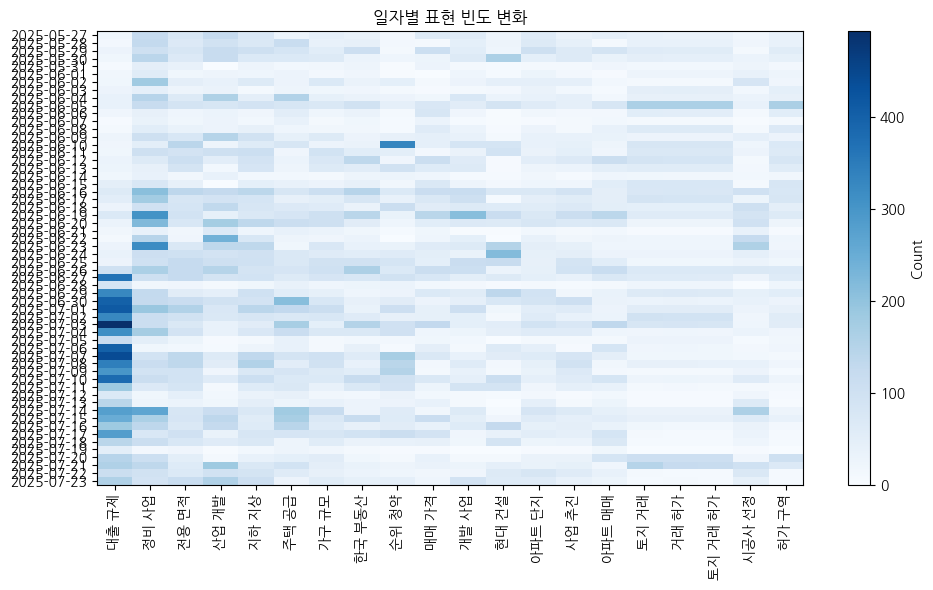

In [ ]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# -----------------------------
# 1) 데이터 로드 & 전처리
# -----------------------------
path = '/content/drive/MyDrive/DSL-2/edadata/1monthcontentreal.csv'   # <-- 경로 수정
df = pd.read_csv(path)
df.columns = ['date','link','title','content']

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
df['title']   = df['title'].fillna('')
df['content'] = df['content'].fillna('')
df['text']    = (df['title'] + ' ' + df['content']).str.replace(r'\s+', ' ', regex=True).str.strip()

# (선택) 정책 관련 복합어 사전치환
replacements = {
    r'주택\s*담보\s*대출': '주담대',
    r'총\s*부채\s*원리금\s*상환\s*비율': 'DSR',
    r'담보\s*인정\s*비율': 'LTV',
    r'6\s*억': '6억'
}
for pat, rep in replacements.items():
    df['text'] = df['text'].str.replace(pat, rep, regex=True)

# -----------------------------
# 2) 토크나이저 & 불용어
# -----------------------------
okt = Okt()
stopwords = set([
    '기자','사진','제공','연합뉴스','뉴스','정부','관련','지난','올해','대한','있다','했다','수',
    '등','또','및','것','때문','그리고','그러나','하지만','서울','시장','미래','기업','대표','설명','가구 가구'
    # 결과 보면서 계속 추가하세요
])

def tokenizer(text):
    nouns = okt.nouns(text)
    return [w for w in nouns if len(w) > 1 and w not in stopwords]

# -----------------------------
# 3) 2~3그램 표현 추출 (CountVectorizer)
# -----------------------------
cv = CountVectorizer(
    tokenizer=tokenizer,
    token_pattern=None,   # tokenizer 사용 시
    ngram_range=(2,3),    # 2~3그램
    min_df=3,             # 3문서 이상 등장
    max_df=0.5            # 50% 이상 문서에 나오면 너무 일반적이라 제외
)
X = cv.fit_transform(df['text'])
terms = cv.get_feature_names_out()

# 전체 빈도
total_freq = np.asarray(X.sum(axis=0)).ravel()
freq_df = pd.DataFrame({'phrase': terms, 'freq': total_freq}).sort_values('freq', ascending=False)
freq_df = freq_df[~freq_df['phrase'].str.match(r'^(\S+)\s+\1$')]
# ★ 중복 단어 반복(예: '가구 가구') 제거
mask = freq_df['phrase'].apply(lambda x: len(set(x.split())) > 1)
freq_df = freq_df[mask].reset_index(drop=True)

print("=== 전체 상위 표현 ===")
print(freq_df.head(30))

# -----------------------------
# 4) 일자별 Top N 표현 뽑기
# -----------------------------
# 일자별 합산 행렬 만들기
dates = df['date'].dt.date.unique()
dates = np.sort(dates)

rows = []
for d in dates:
    idx = np.where(df['date'].dt.date.values == d)[0]  # 정수 인덱스 배열
    vec = X[idx].sum(axis=0).A1
    rows.append(vec)

day_matrix = np.vstack(rows)  # shape: (num_days, num_terms)
day_df = pd.DataFrame(day_matrix, index=dates, columns=terms)

# 일자별 상위 N개 표현 추출
N = 10
daily_top = {}
for d in dates:
    row = day_df.loc[d]
    idxs = row.values.argsort()[::-1][:N]
    daily_top[d] = list(zip(row.index[idxs], row.values[idxs]))

print("\n=== 일자별 Top 표현 ===")
for d, lst in daily_top.items():
    print(f"\n[{d}]")
    for p, f in lst:
        print(f"  {p} : {int(f)}")

# -----------------------------
# 5) (선택) 상위 표현들 히트맵으로 시각화
# -----------------------------
# 상위 K개 표현만 골라 히트맵 (전체 일수/표현수가 작으니 바로 해도 OK)
K = 20
top_terms = freq_df.head(K)['phrase'].tolist()
heat = day_df[top_terms]

plt.figure(figsize=(10, 6))
plt.imshow(heat, aspect='auto', cmap='Blues')
plt.colorbar(label='Count')
plt.yticks(range(len(dates)), dates)
plt.xticks(range(K), top_terms, rotation=90)
plt.title('일자별 표현 빈도 변화')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import datetime

# 1) pivot 날짜 정의
pivot_date = datetime.date(2025, 6, 27)

# 2) day_df: 일자별(행)×표현(열) 빈도 매트릭스
#    dates = day_df.index (dtype: datetime.date)

# 3) 기간별 합산
pre_df  = day_df[day_df.index <  pivot_date]
post_df = day_df[day_df.index >= pivot_date]

pre_freq  = pre_df.sum(axis=0)
post_freq = post_df.sum(axis=0)

# 4) 상위 N개 추출
N = 80
pre_top  = pre_freq.nlargest(N)
post_top = post_freq.nlargest(N)

# 5) 결과 출력
print(f"=== 정책 이전(~{pivot_date - pd.Timedelta(days=1)}) 상위 {N} 표현 ===")
for phrase, cnt in pre_top.items():
    print(f"  {phrase} : {int(cnt)}")

print(f"\n=== 정책 이후({pivot_date}~) 상위 {N} 표현 ===")
for phrase, cnt in post_top.items():
    print(f"  {phrase} : {int(cnt)}")


=== 정책 이전(~2025-06-26) 상위 80 표현 ===
  정비 사업 : 3546
  산업 개발 : 2581
  지하 지상 : 2161
  전용 면적 : 2105
  가구 가구 : 1932
  한국 부동산 : 1710
  개발 사업 : 1695
  주택 공급 : 1655
  가구 규모 : 1629
  매매 가격 : 1606
  전면 구역 : 1533
  현대 건설 : 1479
  토지 거래 : 1472
  허가 구역 : 1455
  거래 허가 : 1452
  용산정 비창 : 1450
  토지 거래 허가 : 1447
  압구정 구역 : 1441
  거래 허가 구역 : 1403
  시공사 선정 : 1334
  사업 추진 : 1329
  순위 청약 : 1313
  아파트 매매 : 1298
  아파트 단지 : 1286
  아파트 가격 : 1112
  재건축 사업 : 1038
  삼성 물산 : 1030
  구역 재개발 : 1029
  구역 지정 : 1015
  비창 전면 : 1013
  주거 환경 : 1012
  용산정 비창 전면 : 1007
  비창 전면 구역 : 1006
  개포 우성 : 960
  공동 주택 : 951
  정비 계획 : 931
  현대 산업 : 928
  현대 산업 개발 : 928
  가격 상승 : 922
  공급 확대 : 918
  전세 사기 : 917
  재개발 사업 : 908
  대출 규제 : 890
  아파트 매매 가격 : 875
  지하철 호선 : 863
  전월 대비 : 847
  건설 경기 : 845
  재판매 금지 : 839
  집값 상승 : 837
  토지 주택 : 837
  주택 가구 : 823
  가구 가구 가구 : 818
  주택 가격 : 781
  롯데 건설 : 775
  도시 개발 : 756
  일반 분양 : 756
  주택 공사 : 749
  산업 단지 : 746
  국제 업무 : 738
  한국 토지 : 736
  업무 협약 : 731
  금호 건설 : 716
  면적 가구 : 715
  규제 완화 : 714


In [ ]:
def window_top_phrases(day_df, dates, window_size=3, top_n=10):
    """
    non-overlapping window로 묶어서 구간별 top_n 추출
    - day_df: DataFrame, index=date, columns=terms
    - dates: array of dates, same order as day_df.index
    - window_size: int, 몇 일씩 묶을지
    - top_n: 각 구간에서 뽑을 키워드 개수
    Returns: dict { "start~end": [(phrase, count), ...], ... }
    """
    # 블록 인덱스 계산
    block_idx = np.arange(len(dates)) // window_size
    # group sum
    grouped = day_df.groupby(block_idx).sum()

    # 구간별 라벨
    labels = []
    for b in sorted(grouped.index.unique()):
        start = dates[b*window_size]
        end   = dates[min((b+1)*window_size-1, len(dates)-1)]
        labels.append(f"{start}~{end}")

    result = {}
    terms = day_df.columns
    for b, label in zip(sorted(grouped.index.unique()), labels):
        vec = grouped.loc[b].values
        idxs = vec.argsort()[::-1][:top_n]
        result[label] = [(terms[i], int(vec[i])) for i in idxs]
    return result

# 예시: 3일, 7일, 14일 단위로 뽑아보기
for w in [7]:
    print(f"\n=== {w}일 단위 Top 표현 ===")
    wt = window_top_phrases(day_df, dates, window_size=w, top_n=15)
    for period, lst in wt.items():
        print(f"\n[{period}]")
        for phrase,count in lst:
            print(f"  {phrase} : {count}")


=== 7일 단위 Top 표현 ===

[2025-05-27~2025-06-02]
  정비 사업 : 776
  산업 개발 : 514
  전세 사기 : 432
  지하 지상 : 428
  전용 면적 : 388
  주택 공급 : 362
  아파트 단지 : 350
  소셜 믹스 : 342
  압구정 구역 : 341
  삼성 물산 : 333
  한남 구역 : 312
  가구 가구 : 297
  주택 가구 : 295
  현대 건설 : 292
  가구 규모 : 289

[2025-06-03~2025-06-09]
  정비 사업 : 532
  산업 개발 : 501
  주택 공급 : 407
  허가 구역 : 404
  토지 거래 : 403
  거래 허가 : 401
  토지 거래 허가 : 399
  거래 허가 구역 : 395
  가구 가구 : 375
  전용 면적 : 324
  지하 지상 : 316
  공급 확대 : 313
  매매 가격 : 311
  용산정 비창 : 283
  파크 사이드 : 277

[2025-06-10~2025-06-16]
  전용 면적 : 611
  순위 청약 : 606
  정비 사업 : 571
  지하 지상 : 534
  한국 부동산 : 482
  토지 거래 : 462
  거래 허가 : 459
  토지 거래 허가 : 457
  허가 구역 : 439
  매매 가격 : 432
  거래 허가 구역 : 430
  가구 규모 : 402
  개발 사업 : 381
  가구 가구 : 370
  산업 개발 : 354

[2025-06-17~2025-06-23]
  정비 사업 : 1300
  산업 개발 : 874
  전면 구역 : 724
  용산정 비창 : 657
  시공사 선정 : 629
  지하 지상 : 601
  개발 사업 : 550
  압구정 구역 : 503
  비창 전면 : 463
  비창 전면 구역 : 460
  용산정 비창 전면 : 457
  롯데 건설 : 442
  전용 면적 : 439
  가구 규모 : 439
  매매 가격 : 417

[2025-06-

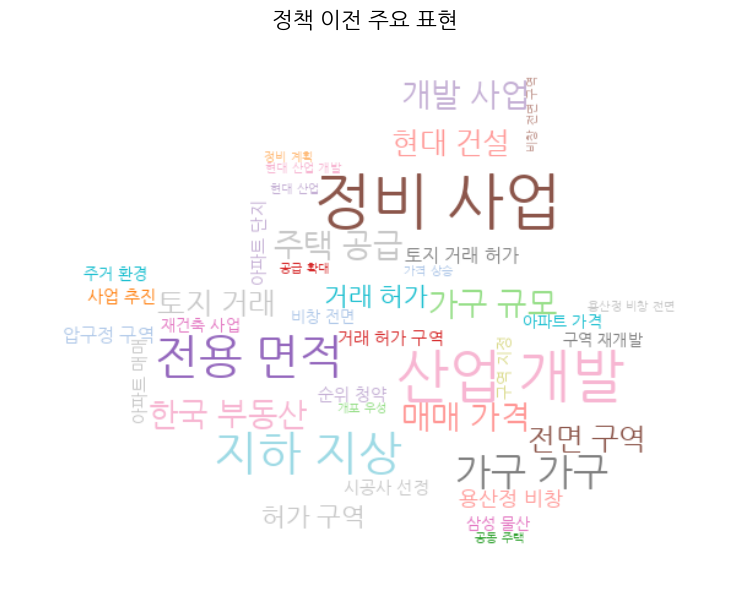

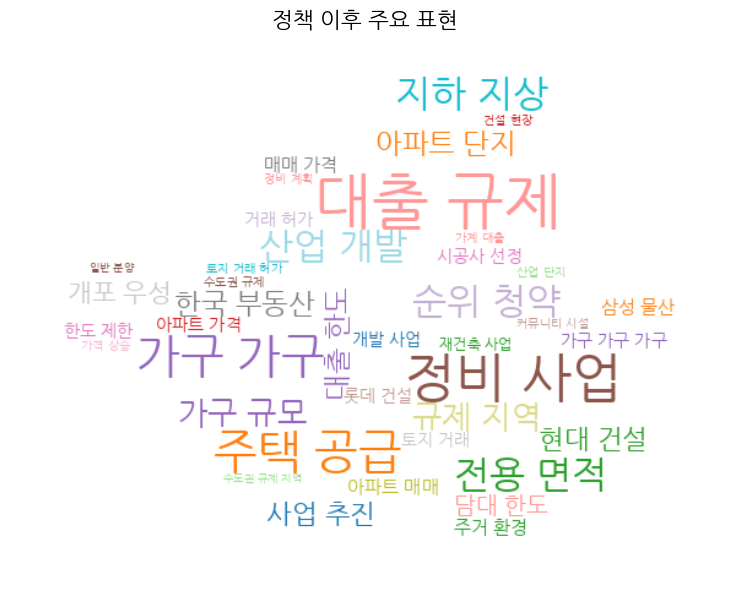

In [ ]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────
# 1) 준비된 마스크 이미지 로드 (서울 지도 형태)
# ─────────────────────────────────────────────
mask_img = np.array(Image.open("/content/drive/MyDrive/DSL-2/DSL-1/자치구별 뉴스 크롤링/서울 지도 형태.png"))

# ─────────────────────────────────────────────
# 2) WordCloud 설정 (정책 전/후 동일)
# ─────────────────────────────────────────────
wc = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    background_color='white',
    mask=mask_img,          # ← 방금 올려주신 그림 사용
    width=1200, height=800,
    max_words=40,
    max_font_size=400,
    min_font_size=1,
    relative_scaling=0.2,
    prefer_horizontal=0.9,
    colormap='tab20'
)

# ─────────────────────────────────────────────
# 3) pre_top, post_top → dict 변환
#    (이미 계산된 Series 라 가정)
# ─────────────────────────────────────────────
pre_dict  = pre_top.to_dict()
post_dict = post_top.to_dict()

# ─────────────────────────────────────────────
# 4) 정책 이전 워드클라우드
# ─────────────────────────────────────────────
wc_pre = wc.generate_from_frequencies(pre_dict)
plt.figure(figsize=(10,6))
plt.imshow(wc_pre, interpolation='bilinear')
plt.axis('off')
plt.title(f'정책 이전 주요 표현', fontsize=16)
plt.tight_layout()
plt.show()
wc_pre.to_file('wordcloud_pre_policy_map.png')

# ─────────────────────────────────────────────
# 5) 정책 이후 워드클라우드
# ─────────────────────────────────────────────
wc_post = wc.generate_from_frequencies(post_dict)
plt.figure(figsize=(10,6))
plt.imshow(wc_post, interpolation='bilinear')
plt.axis('off')
plt.title(f'정책 이후 주요 표현', fontsize=16)
plt.tight_layout()
plt.show()
wc_post.to_file('wordcloud_post_policy_map.png')


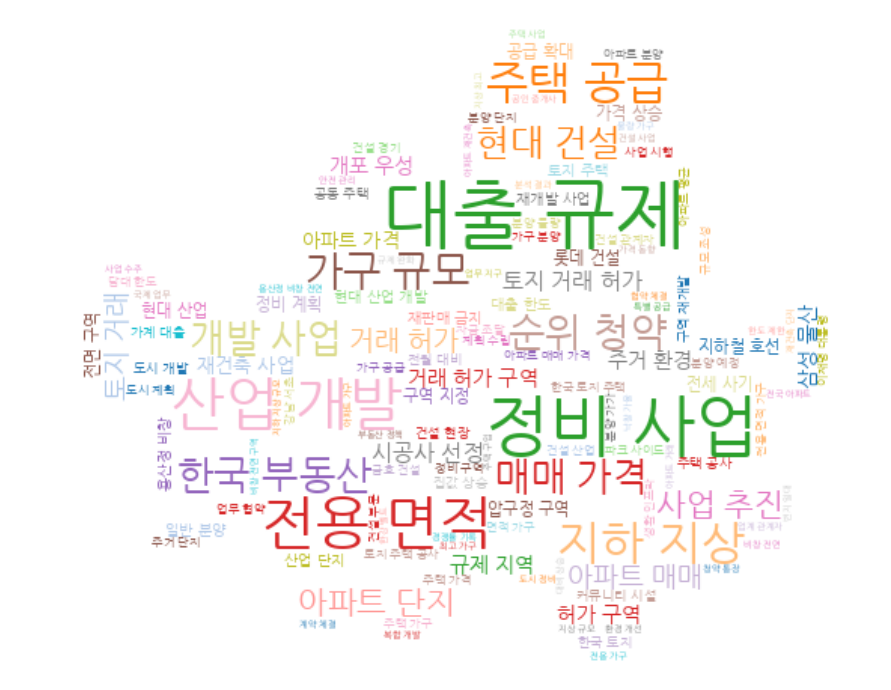

In [ ]:
# ───────────────────────
# 0. 준비
# ───────────────────────
from PIL import Image
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# (Colab) 한글 폰트 & 경고 처리
!apt-get -qq -y install fonts-nanum > /dev/null
import matplotlib
from matplotlib import font_manager, rcParams
import warnings
font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
rcParams['font.family'] = 'NanumGothic'
rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore", message="Glyph .* missing from font")

# ───────────────────────
# 1. freq_df -> dict 만들기
#    (freq_df: ['phrase','freq']가 있다고 가정)
# ───────────────────────
# 중복 토큰 표현 제거 (예: '가구 가구')
freq_df = freq_df[~freq_df['phrase'].astype(str).str.match(r'^(\S+)\s+\1$')]

# 필요하면 추가 필터(한 글자 제거, 숫자만 등)
freq_df = freq_df[freq_df['phrase'].str.len() > 1]

# 딕셔너리 변환
freq_dict = dict(zip(freq_df['phrase'], freq_df['freq']))

# ───────────────────────
# 2. 마스크(선택)
# ───────────────────────
# 마스크를 쓰고 싶지 않으면 mask_img = None 로 두세요.
mask_path = "/content/drive/MyDrive/DSL-2/DSL-1/자치구별 뉴스 크롤링/서울 지도 형태.png"  # 수정
mask_img  = np.array(Image.open(mask_path))  # 없으면 주석 처리

# ───────────────────────
# 3. 워드클라우드 생성
# ───────────────────────
wc = WordCloud(
    font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    background_color="white",
    mask=mask_img,            # 마스크 사용 안 할 땐 None
    width=1600, height=1200,
    max_words=400,
    max_font_size=140,
    min_font_size=6,
    relative_scaling=0.5,     # 0~1 사이: 값이 클수록 빈도 차이 크게 반영
    colormap="tab20"          # 색 팔레트 (원하면 변경/삭제)
)

wordcloud = wc.generate_from_frequencies(freq_dict)

# ───────────────────────
# 4. 시각화 & 저장
# ───────────────────────
plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

# 파일 저장
wordcloud.to_file("wordcloud_top_phrases.png")


감성 분석 진행


In [ ]:
# ── 1) 다운로드 (Colab/터미널)
!rm -f SentiWord_info.json
!wget -q -O SentiWord_info.json \
  https://raw.githubusercontent.com/park1200656/KnuSentiLex/master/KnuSentiLex/data/SentiWord_info.json


Loaded 14841 sentiment words


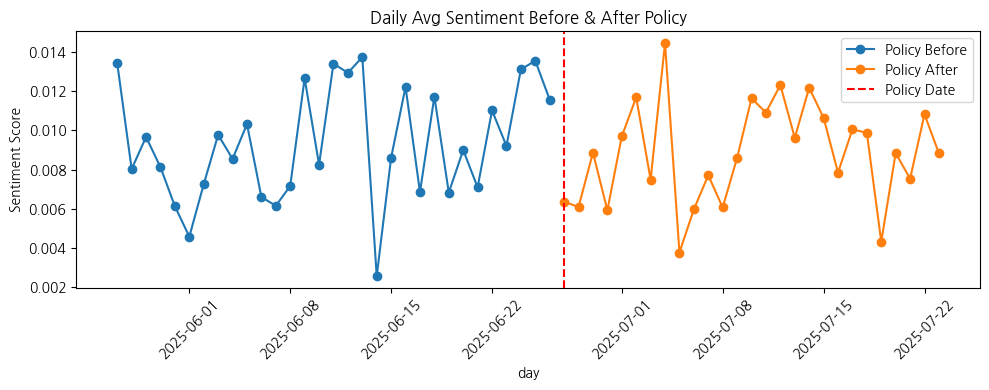

<Figure size 1000x400 with 0 Axes>

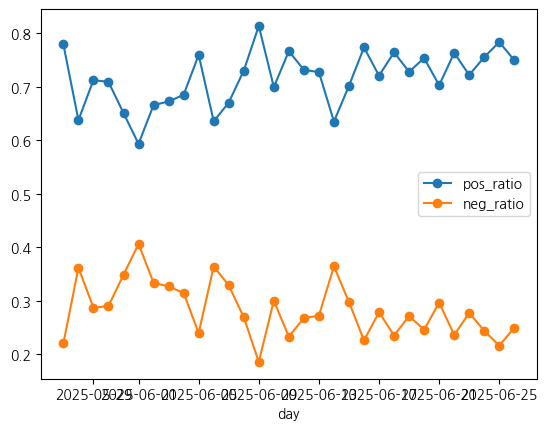

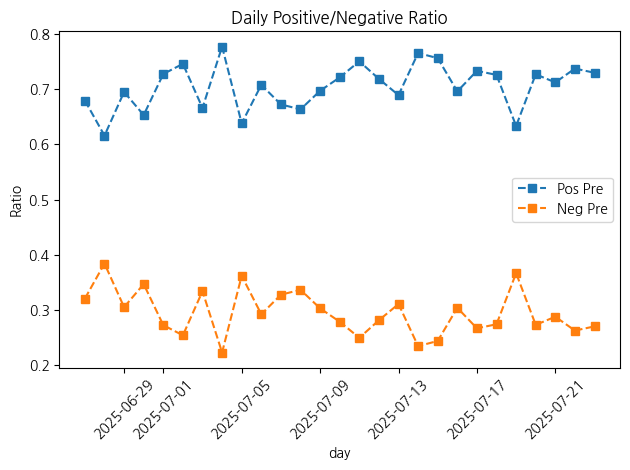

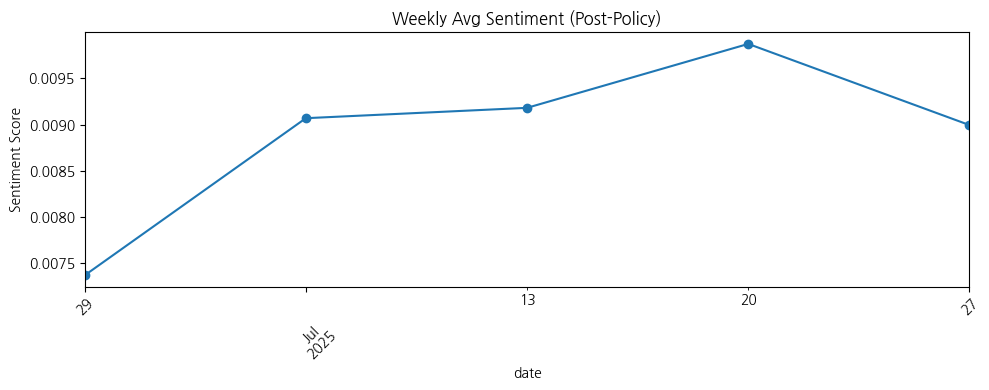

In [ ]:
# =========================================
# 0) KNU 감성사전 JSON 다운로드 & 로드
# =========================================
!rm -f SentiWord_info.json
!wget -q -O SentiWord_info.json \
    https://raw.githubusercontent.com/park1200656/KnuSentiLex/master/KnuSentiLex/data/SentiWord_info.json

import json, pandas as pd, numpy as np

with open('SentiWord_info.json','r',encoding='utf-8') as f:
    js = json.load(f)

# JSON → DataFrame
if isinstance(js, list):
    lex = pd.DataFrame(js)
else:
    rows = []
    for k,v in js.items():
        if isinstance(v, dict):
            v['word'] = v.get('word',k)
            rows.append(v)
        else:
            rows.append({'word':k,'polarity':v})
    lex = pd.DataFrame(rows)

# 컬럼 정리 & 숫자 변환
lex = lex.rename(columns={c:'polarity' for c in lex.columns if 'polarity' in c})
lex['polarity'] = pd.to_numeric(lex['polarity'], errors='coerce')
lex = lex.dropna(subset=['polarity'])
max_abs = lex['polarity'].abs().max()
if max_abs>1:
    lex['polarity'] /= max_abs

senti_dict = dict(zip(lex['word'], lex['polarity']))
print(f"Loaded {len(senti_dict)} sentiment words")

# =========================================
# 1) 기사별 감성 점수 계산
#    (df, tokenizer 이미 정의된 상태 가정)
# =========================================
def lexicon_sentiscore(text):
    toks = tokenizer(text)
    if not toks:
        return 0.0
    vals = [senti_dict.get(t,0) for t in toks]
    return float(np.sum(vals)/len(toks))

def count_pos_neg(tokens):
    pos = sum(senti_dict.get(t,0)>0 for t in tokens)
    neg = sum(senti_dict.get(t,0)<0 for t in tokens)
    return pos, neg

df['sentiscore'] = df['text'].apply(lexicon_sentiscore)
df[['pos_cnt','neg_cnt']] = df['text'].apply(
    lambda x: pd.Series(count_pos_neg(tokenizer(x)))
)

# =========================================
# 2) 정책 전/후 분리
# =========================================
import datetime
pivot = datetime.date(2025,6,27)
df['day'] = df['date'].dt.date

df_pre  = df[df['day'] <  pivot]
df_post = df[df['day'] >= pivot]

# =========================================
# 3) 일별 감성 집계 (Pre & Post)
# =========================================
def daily_agg(sub):
    d = sub.groupby('day').agg(
        senti_mean=('sentiscore','mean'),
        pos_sum   =('pos_cnt','sum'),
        neg_sum   =('neg_cnt','sum'),
        n         =('sentiscore','count'))
    d['pos_ratio'] = d['pos_sum']/(d['pos_sum']+d['neg_sum']+1e-9)
    d['neg_ratio'] = d['neg_sum']/(d['pos_sum']+d['neg_sum']+1e-9)
    return d

daily_pre  = daily_agg(df_pre)
daily_post = daily_agg(df_post)

# =========================================
# 4) 주간 감성 집계 (Post만)
# =========================================
weekly_post = (df_post
    .set_index('date')
    .resample('W')
    .agg(senti_mean=('sentiscore','mean'),
         pos_sum   =('pos_cnt','sum'),
         neg_sum   =('neg_cnt','sum'),
         n         =('sentiscore','count')))
weekly_post['pos_ratio'] = weekly_post['pos_sum']/(weekly_post['pos_sum']+weekly_post['neg_sum']+1e-9)
weekly_post['neg_ratio'] = weekly_post['neg_sum']/(weekly_post['pos_sum']+weekly_post['neg_sum']+1e-9)

# =========================================
# 5) 시각화
# =========================================
import matplotlib.pyplot as plt

# (1) 일별 평균 감성: 정책 전/후 비교
plt.figure(figsize=(10,4))
daily_pre['senti_mean'].plot(marker='o', label='Policy Before')
daily_post['senti_mean'].plot(marker='o', label='Policy After')
plt.axvline(pivot, color='red', ls='--', label='Policy Date')
plt.title('Daily Avg Sentiment Before & After Policy')
plt.ylabel('Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (2) 일별 긍/부정 비율: 정책 전/후
plt.figure(figsize=(10,4))
daily_pre[['pos_ratio','neg_ratio']].plot(marker='o')
daily_post[['pos_ratio','neg_ratio']].plot(marker='s', ls='--')
plt.title('Daily Positive/Negative Ratio')
plt.ylabel('Ratio')
plt.legend(['Pos Pre','Neg Pre','Pos Post','Neg Post'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# (3) 주간 평균 감성: 정책 후
plt.figure(figsize=(10,4))
weekly_post['senti_mean'].plot(marker='o')
plt.title('Weekly Avg Sentiment (Post-Policy)')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================================
# 6) 결과 저장
# =========================================
daily_pre.to_csv('daily_sent_pre.csv',  encoding='utf-8-sig')
daily_post.to_csv('daily_sent_post.csv',encoding='utf-8-sig')
weekly_post.to_csv('weekly_sent_post.csv',encoding='utf-8-sig')


In [ ]:
# --- JSON 로딩 후 lex 만들었다는 가정 ---
# lex.columns 안에 'polarity'가 있고 값이 문자열일 수 있음

# 1) 우선 문자열 → 숫자 변환
lex['polarity'] = pd.to_numeric(lex['polarity'], errors='coerce')

# 2) 혹시 'POS','NEG','0' 같은 라벨이면 매핑
# (필요 시 활성화)
# mapping = {'POS': 1, 'NEG': -1, '0': 0, 'NONE': 0, 'neu': 0}
# lex['polarity'] = lex['polarity'].map(mapping).fillna(lex['polarity'])

# 3) 숫자로 못 바꾼 행 제거
lex = lex.dropna(subset=['polarity'])

# 4) 점수 스케일 정규화(선택)
max_abs = lex['polarity'].abs().max()
if max_abs > 1:
    lex['polarity'] = lex['polarity'] / max_abs

# 5) 딕셔너리로 변환
senti_dict = dict(zip(lex['word'], lex['polarity']))
print(f"사전 단어 수: {len(senti_dict):,}")


사전 단어 수: 14,841
